In [1]:
!pip install tensorflow keras


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import os
import cv2
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [3]:
# Define the image size and path to the image folder
IMAGE_SIZE = (224, 224)
TRAIN_IMAGE_FOLDER = 'Training_Set/Training_Set/Training'
VALID_IMAGE_FOLDER = 'Evaluation_Set/Evaluation_Set/Validation'
TEST_IMAGE_FOLDER = 'Test_Set/Test_Set/Test'

In [4]:
def load_image(img_path):
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.resize(img, IMAGE_SIZE)
    return img

def load_data(csv_path, image_folder):
    data = pd.read_csv(csv_path)
    images = []
    labels = []

    img_paths = [os.path.join(image_folder, str(row['ID']) + '.png') for index, row in data.iterrows()]
    
    with ThreadPoolExecutor() as executor:
        images = list(tqdm(executor.map(load_image, img_paths), total=len(img_paths)))

    images = [img for img in images if img is not None]
    labels = [row.drop('ID').values for index, row in data.iterrows() if load_image(os.path.join(image_folder, str(row['ID']) + '.png')) is not None]
    
    images = np.array(images, dtype='float32') / 255.0
    labels = np.array(labels, dtype='float32')
    return images, labels, data

In [5]:
# Load train, validation, and test datasets
X_train, y_train, train_data = load_data('Training_Set/Training_Set/RFMiD_Training_Labels.csv', TRAIN_IMAGE_FOLDER)
X_valid, y_valid, valid_data = load_data('Evaluation_Set/Evaluation_Set/RFMiD_Validation_Labels.csv', VALID_IMAGE_FOLDER)
X_test, y_test, test_data = load_data('Test_Set/Test_Set/RFMiD_Testing_Labels.csv', TEST_IMAGE_FOLDER)

100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [00:09<00:00, 68.07it/s]


In [6]:
# Define a simple CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(y_train.shape[1], activation='sigmoid')
])

C:\Users\91914\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [8]:
# Train the model
model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_valid, y_valid))

Epoch 1/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 26s 353ms/step - accuracy: 0.5424 - loss: 0.4184 - val_accuracy: 1.0000 - val_loss: 0.1080
Epoch 2/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 19s 315ms/step - accuracy: 0.8526 - loss: 0.1441 - val_accuracy: 1.0000 - val_loss: 0.0986
Epoch 3/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 19s 323ms/step - accuracy: 0.9173 - loss: 0.1200 - val_accuracy: 1.0000 - val_loss: 0.0962
Epoch 4/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 22s 360ms/step - accuracy: 0.9622 - loss: 0.1147 - val_accuracy: 1.0000 - val_loss: 0.0955
Epoch 5/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 21s 350ms/step - accuracy: 0.9669 - loss: 0.1086 - val_accuracy: 1.0000 - val_loss: 0.0969
Epoch 6/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 21s 343ms/step - accuracy: 0.9789 - loss: 0.1051 - val_accuracy: 1.0000 - val_loss: 0.0946
Epoch 7/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 330ms/step - accuracy: 0.9910 - loss: 0.1021 - val_accuracy: 1.0000 - val_loss: 0.0944
Epoch 8/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 21s 357ms/step - accuracy: 0.9859 - loss: 0.1017 - val_accu

In [13]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix

# Assuming y_test and y_pred are multilabel arrays
report = classification_report(y_test, y_pred, output_dict=True)

# Extract metrics for class 0
class_0_report = report['0']  # Get class 0 metrics

# Get precision, recall, F1 score for class 0
precision_class_0 = class_0_report['precision']
recall_class_0 = class_0_report['recall']
f1_score_class_0 = class_0_report['f1-score']

# Print the metrics for class 0
print(f"Class 0 Precision: {precision_class_0}")
print(f"Class 0 Recall: {recall_class_0}")
print(f"Class 0 F1 Score: {f1_score_class_0}")

# For multilabel, calculate confusion matrix per label
mcm = multilabel_confusion_matrix(y_test, y_pred)

# Print confusion matrix for class 0 (mcm[0] gives confusion matrix for class 0)
cm_class_0 = mcm[0]
print(f"Confusion Matrix for Class 0:\n{cm_class_0}")


Class 0 Precision: 0.8378378378378378
Class 0 Recall: 0.9802371541501976
Class 0 F1 Score: 0.9034608378870674
Confusion Matrix for Class 0:
[[ 38  96]
 [ 10 496]]


C:\Users\91914\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\91914\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\91914\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

In [16]:
from sklearn.metrics import accuracy_score

# If the labels are binary (0 or 1), check if predictions are binary
train_preds = (model.predict(X_train) > 0.5).astype(int)  # Convert to binary labels
valid_preds = (model.predict(X_valid) > 0.5).astype(int)
test_preds = (model.predict(X_test) > 0.5).astype(int)

# Ensure y_train is binary as well
train_accuracy = accuracy_score(y_train, train_preds)
valid_accuracy = accuracy_score(y_valid, valid_preds)
test_accuracy = accuracy_score(y_test, test_preds)

# Print out the accuracy for each dataset
print(f"Train Accuracy: {train_accuracy}")
print(f"Validation Accuracy: {valid_accuracy}")
print(f"Test Accuracy: {test_accuracy}")


60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step
Train Accuracy: 0.1671875
Validation Accuracy: 0.1109375
Test Accuracy: 0.1328125


In [18]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 1.0000 - loss: 0.0989
Test accuracy: 1.0


In [15]:
# Predict on the test set
predictions = model.predict(X_test)
predictions = (predictions > 0.5).astype(int)

# For a particular image, output all column names for which the value is 1
for i, prediction in enumerate(predictions):
    print(f'Image: {test_data["ID"].iloc[i]}')
    present_diseases = [test_data.columns[j+1] for j in range(len(prediction)) if prediction[j] == 1]
    print('Present Diseases:', present_diseases)

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step
Image: 1
Present Diseases: ['Disease_Risk', 'MH']
Image: 2
Present Diseases: ['Disease_Risk']
Image: 3
Present Diseases: ['Disease_Risk', 'ODC']
Image: 4
Present Diseases: ['Disease_Risk']
Image: 5
Present Diseases: ['Disease_Risk']
Image: 6
Present Diseases: ['Disease_Risk']
Image: 7
Present Diseases: ['Disease_Risk']
Image: 8
Present Diseases: ['Disease_Risk']
Image: 9
Present Diseases: ['Disease_Risk']
Image: 10
Present Diseases: ['Disease_Risk', 'ODC']
Image: 11
Present Diseases: ['Disease_Risk']
Image: 12
Present Diseases: ['Disease_Risk']
Image: 13
Present Diseases: ['Disease_Risk']
Image: 14
Present Diseases: ['Disease_Risk']
Image: 15
Present Diseases: ['Disease_Risk', 'TSLN']
Image: 16
Present Diseases: ['Disease_Risk']
Image: 17
Present Diseases: ['Disease_Risk', 'DR']
Image: 18
Present Diseases: ['Disease_Risk', 'ODC']
Image: 19
Present Diseases: ['Disease_Risk']
Image: 20
Present Diseases: ['Disease_Risk']
Image: 21
Present Diseases: 

In [16]:
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np

def predict_diseases(image_path, model, data_columns):
    # Load the image
    img = cv2.imread(image_path)
    img = cv2.resize(img, IMAGE_SIZE)  # Resize to match the input shape of the model
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    img = img / 255.0  # Normalize the image
    
    # Predict the diseases (output of the model)
    prediction = model.predict(img)
    prediction = (prediction > 0.5).astype(int)  # Convert probabilities to binary (0 or 1)
    
    # Get the diseases that are present (i.e., where prediction == 1)
    present_diseases = [data_columns[j+1] for j in range(len(prediction[0])) if prediction[0][j] == 1]
    
    # Display the image
    img_display = cv2.imread(image_path)
    img_display = cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for displaying in matplotlib
    
    plt.imshow(img_display)
    plt.axis('off')  # Hide axes
    plt.show()
    
    # Display the diseases present
    print('Present Diseases:', present_diseases)

In [5]:
# Example Usage
image_path = 'Training_Set/Training_Set/Training/6.png'  # Provide the path to the image you want to classify
# predict_diseases(image_path, model, test_data.columns)

In [2]:
import joblib

# Save the trained model
joblib.dump(model, 'heart_disease_risk_model.pkl')

NameError: name 'model' is not defined

In [4]:
import joblib

# Load the model
loaded_model = joblib.load('heart_disease_risk_model.pkl')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
Raw prediction probabilities: [9.06791151e-01 8.07082746e-03 5.13901949e-01 8.55373032e-03
 3.64899524e-02 6.73644662e-01 7.09884102e-03 1.36848971e-01
 2.32316018e-03 2.22274149e-03 1.55767202e-02 6.91593485e-03
 9.19451267e-02 4.04395582e-03 9.60455800e-04 5.95576770e-04
 5.45623265e-02 1.35121560e-02 4.07810381e-04 4.03021276e-03
 2.16490170e-03 4.49418440e-04 1.30474160e-03 1.86088751e-03
 2.34205020e-03 2.43299757e-03 1.20230403e-03 4.15576127e-04
 7.93291256e-05 2.88600640e-05 6.89494482e-06 1.22209094e-04
 9.82005731e-05 5.29064255e-06 1.01723395e-04 4.93432488e-03
 2.49221339e-04 7.54099805e-04 4.42199782e-03 2.82956739e-06
 1.43295356e-05 1.47632491e-05 1.50464439e-05 3.63880608e-05
 2.66113693e-05 3.75070631e-05]


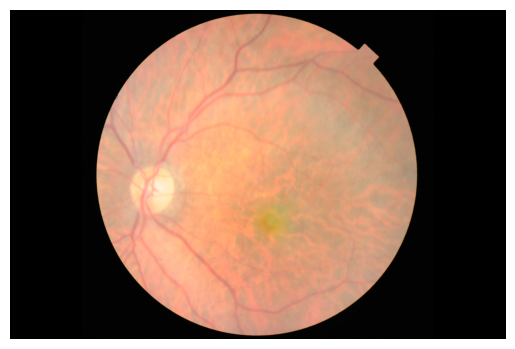

Present Diseases: ['Disease_Risk', 'ARMD', 'MYA']


In [30]:
predict_diseases(image_path, loaded_model, test_data.columns)